In [1]:
# おまじない
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font=['Noto Sans JP'], font_scale=1.5)
import numpy as np
import pandas as pd
np.set_printoptions(
    precision=3,
    suppress=True,
    formatter={'float': '{:0.3f}'.format}
)

# マハラノビス変換とは何かを考える

* 多くの機械学習ライブラリにおける距離の計算はユークリッド距離決め打ちなので、距離としてマハラノビス距離を使うことは難しい
* そこで、ユークリッド距離を計算したらマハラノビス距離になるようにデータを変換した
* これをマハラノビス変換と呼んだ
* このマハラノビス変換には以下のような性質がある
    * 変換された各特徴量（軸）は正規化（平均0, 分散1）されている
    * 軸はすべて直行する（特徴量間の相関を無くす：ホワイトノイズ化）
    * バイナリ変数、そしてダミー変数化すればカテゴリ変数も使うことが出来る
* ３つ目の特徴はマハラノビス変換にしかないが、相関を無くすといえば PCA（主成分分析）も同じような性質を持っている
* PCA と比較し、軸や固有ベクトルについて考えることで、マハラノビス変換とは何なのかを考えたい

## 準備

In [2]:
from sklearn.preprocessing import StandardScaler

# 多変量正規分布の乱数を生成し、正規化したものを元データとする
n_X = 1000
m = np.array([0, 0])
K = np.array([[2, -2], [-2, 4]])
np.random.seed(seed=12)
X = np.random.multivariate_normal(mean=m, cov=K, size=n_X)
X = StandardScaler().fit_transform(X)
# DataFrame にする
X = pd.DataFrame(X, columns=['x1', 'x2'])

In [3]:
from typing import Optional
from sklearn.base import TransformerMixin


# データを表示する関数
def draw_data_scatter(
    X: pd.DataFrame,
    transformer: Optional[TransformerMixin],
    title: str
) -> None:
    columns = X.columns
    # データの変換
    if transformer is None:
        X = X.copy()
    else:
        X = transformer.transform(X)
        X = pd.DataFrame(X, columns=columns)
    # 固有値固有ベクトルの計算
    eig_vals, eig_vecs = np.linalg.eig(np.cov(X, rowvar=False))
    # 生成した乱数の表示
    fig, ax = plt.subplots(figsize=(6, 6))
    X.plot(
        kind='scatter', x=columns[0], y=columns[1],
        color=sns.color_palette('tab10')[0], alpha=0.5, ax=ax
    )
    # 固有ベクトルの表示
    for i, (val, vec) in enumerate(zip(eig_vals, eig_vecs)):
        ax.arrow(
            x=0, y=0, dx=vec[0], dy=vec[1],
            width=0.05, head_width=0.3,
            color=sns.color_palette('tab10')[1], label=f'固有ベクトル{i}'
        )
    # 軸の表示
    axis = np.array([[1, 0]])
    if transformer is None:
        conv_axis = axis[0]
    else:
        axis = pd.DataFrame(axis, columns=columns)
        conv_axis = transformer.transform(axis)[0]
    ax.arrow(
        x=0, y=0, dx=conv_axis[0], dy=conv_axis[1],
        width=0.05, head_width=0.3,
        color=sns.color_palette('tab10')[3], label='x1軸'
    )
    axis = np.array([[0, 1]])
    if transformer is None:
        conv_axis = axis[0]
    else:
        axis = pd.DataFrame(axis, columns=columns)
        conv_axis = transformer.transform(axis)[0]
    ax.arrow(
        x=0, y=0, dx=conv_axis[0], dy=conv_axis[1],
        width=0.05, head_width=0.3,
        color=sns.color_palette('tab10')[3], label='x2軸'
    )
    vmax = X.abs().max().max() * 1.2
    plt.xlim(-vmax, vmax)
    plt.ylim(-vmax, vmax)
    plt.title(title)
    print(f'平均：{X.mean(axis=0).values}, 標準偏差：{X.std(axis=0).values}')
    return

平均：[-0.000 0.000], 標準偏差：[1.001 1.001]


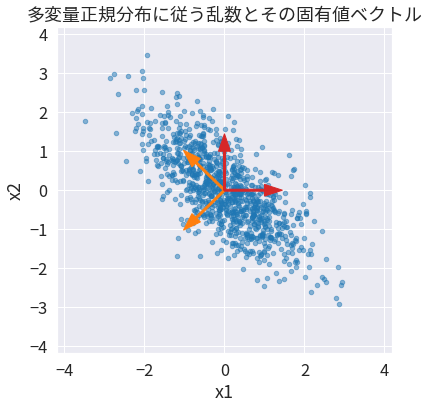

In [4]:
draw_data_scatter(
    X=X,
    transformer=None,
    title='多変量正規分布に従う乱数とその固有値ベクトル'
)

## 元となるデータ

* 元となるデータの精製方法
    * 多変量正規分布に従う乱数を生成
    * さらに各軸（特徴量）が平均0, 分散1 になるよう正規化した
* 上の図の説明
    * データを散布図に表した
    * 赤の矢印が軸（基底ベクトル）を表し、オレンジの矢印が共分散行列の固有ベクトルを表している
* 確認
    * 軸はもちろん直行している
    * 固有ベクトルも勿論直行していて、分散が最も大きい方向（とそれに直行して分散が最も大きい方向）を表している

## PCA（主成分分析）

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
]).fit(X)

平均：[0.000 0.000], 標準偏差：[1.313 0.526]


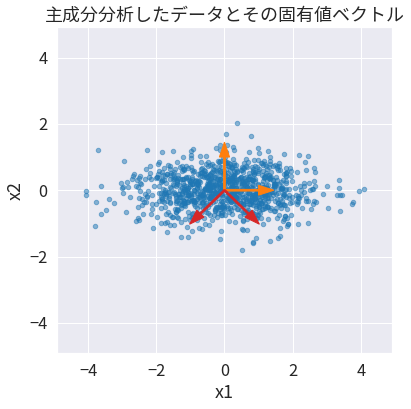

In [6]:
draw_data_scatter(
    X=X,
    transformer=pipe,
    title='主成分分析したデータとその固有値ベクトル'
)

## PCA（主成分分析）したデータ

* 上の図の説明
    * 元データを PCA して、そのデータ点を同様に散布図にプロット
    * 元データにおける軸のベクトルを学習した PCA を使って同様に変換したものが、赤の矢印
        * 元の空間がどのように変形されたのかを表す
    * PCA したデータの共分散行列の固有ベクトルがオレンジの矢印
* ここから分かること
    * PCA というのは、空間を回転（＆反転）して、固有ベクトルがちょうど軸（基底）の方向になるようにする変換
        * 元の空間の基底ベクトルを変換しても、それらは長さを変えずまだ直行する
        * 変換した基底ベクトルと変換後の共分散行列の固有ベクトルのなす角が変化しない

## マハラノビス変換

In [7]:
from mahalanobis_transformer import MahalanobisTransformer

mah = MahalanobisTransformer().fit(X)

平均：[-0.000 -0.000], 標準偏差：[1.000 1.000]


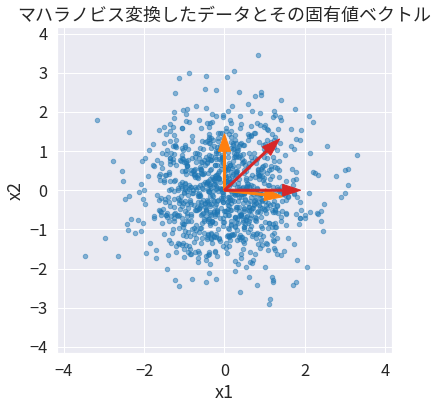

In [8]:
draw_data_scatter(
    X=X,
    transformer=mah,
    title='マハラノビス変換したデータとその固有値ベクトル'
)

## マハラノビス変換したデータ

* 上の図の説明
    * 元データをマハラノビス変換して、そのデータ点を同様に散布図にプロット
    * 元データにおける軸のベクトルを学習したマハラノビス変換で同様に変換したものが、赤の矢印
    * マハラノビス変換したデータの共分散行列の固有ベクトルがオレンジの矢印
* ここから分かること
    * マハラノビス変換は、元の空間を縮めたり伸ばしたりしている
        * 元データの基底ベクトルをマハラノビス変換すると、それらは直行しなくなる
    * 縮めたり伸ばしたりすることで、変換後の各軸の相関を無くしている
    * 共分散行列の固有ベクトルも、変換後の軸と一致するとは限らない

## 考察

* PCA とは何か
    * データにおいて分散が最も大きい要素が結果（目的変数）に最も強く影響を与えるという仮説の下、その分散が一番大きい要素とは何かを探すのが、そもそもの PCA の狙い
    * 分散が一番大きい方向とは、固有値（の絶対値）が最も大きい固有ベクトルの方向である
    * そのため、空間を回転（＆反転）させて、固有ベクトルに軸を合わせていくのが PCA
        * 固有ベクトル同士は直行するため、すべての軸を固有ベクトルに合わせるよう回転させれば、変換後の各軸は自然と相関が無くなるが、これは言わば PCA の副産物
    * いわば、PCA とは「データ自体は何もいじらずに、データを見る方向を色々変えて、最も良さげな解釈を探す」方法である
* そもそも軸って何だっけ
    * 例えば、お菓子の味を数値で表現したいとする
    * 例えば、「甘さ」「しょっぱさ」という２軸で数値化し、お菓子の味を表現するとする
        * この２つだけでは少なすぎるだろうけど（笑）、簡単のため
        * この「甘さ」「しょっぱさ」のデータ（ビッグデータ）と「このお菓子は好きか嫌いか」（アノテーション）を学習し、どんな味がみんな好きな味なのかを予測するのが、AI（機械学習）
    * 要するに、「お菓子の味」というものを表す特徴が、軸（だから特徴量というのだ）
    * 「甘さ」「しょっぱさ」は、良い特徴だと思われる
        * いくら甘くしても、しょっぱくはならない
        * いくらしょっぱくしても、甘くはならない
        * 「甘さ」と「しょっぱさ」には関係が無い、すなわち、相関が無い
    * しかし、もしも「甘さ」「甘じょっぱさ」だったら、悪い特徴だろう
        * 「甘じょっぱさ」が増えても、それは単に「甘さ」が増えたのか、それとも「しょっぱさ」が増えたのか、原因が分からない
        * それはひとえに、「甘さ」と「甘じょっぱさ」にはかなり関係がある、すなわち、相関があるから
    * すなわち、目的を良く表現する特徴、本質を捉えた特徴は、互いに相関が無いはず
* 再び、PCA とは何か
    * 何を軸とするか＝特徴の取り方＝解釈、と言える
    * 特徴量間に相関があるのは、解釈（特徴の取り方）が悪いだろう
    * だからデータを変えずに空間をくるくる回すことで解釈を変え、良い特徴を探そう、というのが PCA
* マハラノビス変換とは何か
    * PCA とは異なり、データ自体を変形させている
        * PCA では分布の形は変わらないのに、マハラノビス変換では分布の形が変わっている
    * これは、良くない特徴量なのは相関があるのが悪いので、無理やりデータから相関要素を取り除くことをやっているに相当すると考える
        * 「甘じょっぱさ」から相関の原因である「甘さ」成分を取り除いて、良い特徴である「しょっぱさ」に変換するように
* まとめ
    * PCA は、解釈（特徴量の取り方）を変えて、良い特徴量を探す方法
    * マハラノビス変換は、解釈自体は良いとして、悪さをする相関成分を特徴量から取り除く方法
* 使い分け
    * PCA
        * 次元削減（分散＝固有値が小さい次元を削除する）
        * 検定（分布を変えたくない）
        * 回帰（分散が重要）
        * バイナリ変数・カテゴリ変数が無い場合
        * そこそこ相関が高い変数がある場合
    * マハラノビス変換
        * 分類・異常検知（ホワイトノイズ化が有効）
        * バイナリ変数・カテゴリ変数がある場合
        * 相関はそれほど高くない場合（逆行列計算がホゲる可能性）

# マハラノビス距離の分布と異常検知

In [9]:
from scipy.spatial.distance import cdist

# マハラノビス変換をし、ユークリッド距離の計算でマハラノビス距離（の２乗）を計算
X_mah = mah.transform(X)
dist_mah = cdist(X_mah, np.zeros((1, 2)), metric='euclidean').ravel()
dist2_mah = dist_mah ** 2
dist2_mah = pd.Series(dist2_mah)

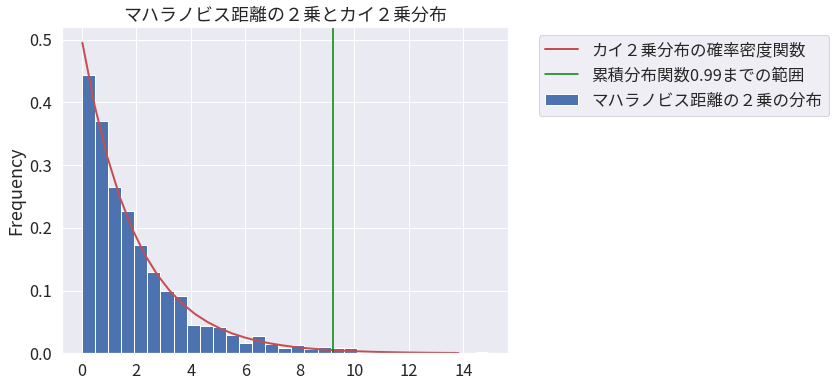

In [10]:
from scipy.stats import chi2

# 分布を表示
fig, ax = plt.subplots(figsize=(8, 6))
bins = int(np.sqrt(n_X))
dist2_mah.plot(
    kind='hist', bins=bins, density=True,
    ax=ax, label='マハラノビス距離の２乗の分布'
)
x = np.linspace(chi2.ppf(0.01, 2), chi2.ppf(0.999, 2), bins)
rv = chi2(2)
ax.plot(x, rv.pdf(x), 'r-', lw=2, label='カイ２乗分布の確率密度関数')
ax.axvline(rv.ppf(0.99), color='green', label='累積分布関数0.99までの範囲')
plt.title('マハラノビス距離の２乗とカイ２乗分布')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

* マハラノビス距離は異常検知によく使われる
    * データが多変量正規分布に従うならば、そのマハラノビス距離の２乗は、特徴量次元を自由度としたカイ２乗分布に従う
    * で、データが正規分布に従わなくても、結構カイ２乗分布に従ってくれる
        * もちろん、大数の法則とか、２項分布と正規分布の関係とか、色々考えられることはある
    * なので実際に見てみる
* 元となるデータ
    * 他変性正規分布に従うよう乱数で作ったデータなので、理想的なデータになる
    * 実際にマハロノビス変換・ノルム計算で計算すると、上の図のように綺麗にカイ２乗分布に従うことが分かる
* 異常検知を行うには
    * データから異常でないデータだけを使って、マハラノビス距離を計算
    * 異常なデータも、上記で学習した分布を使ってマハラノビス距離を計算
    * 上の図のようなヒストグラムを描き、正常と異常が離れているか確認
    * 離れていれば、その隙間に入るように閾値を設定
        * 離れてない場合は、誤検出のリスクをきちんと算出・想定し、閾値を設定
    * 新しく来たデータに対して、同様に今までの分布を使ってマハラノビス距離を計算し、閾値を超えてたら異常検知
* 上の図での異常検知サンプル
    * すべて正常データなので、とりあえず自由度２のカイ２乗分布の累積密度関数に 0.99 を与えた時の値で閾値を設定
        * 緑の縦線
    * いくつかの正常データが閾値より大きいので、良い閾値ではないが、とりあえず例なので

In [11]:
# 累積分布関数 0.99 を閾値とした異常検知を想定し、その境界線を作る
r = np.sqrt(chi2(2).ppf(0.99))
limits_mah = list()
for i in range(100):
    rad = 2.0 * np.pi * i / 100
    limits_mah.append((r * np.cos(rad), r * np.sin(rad)))
limits_mah.append(limits_mah[0])
limits_mah = pd.DataFrame(limits_mah, columns=X.columns)

In [12]:
# 境界線を逆マハラノビス変換し、元の乱数の空間に写像する
limits = mah.inverse_transform(limits_mah)

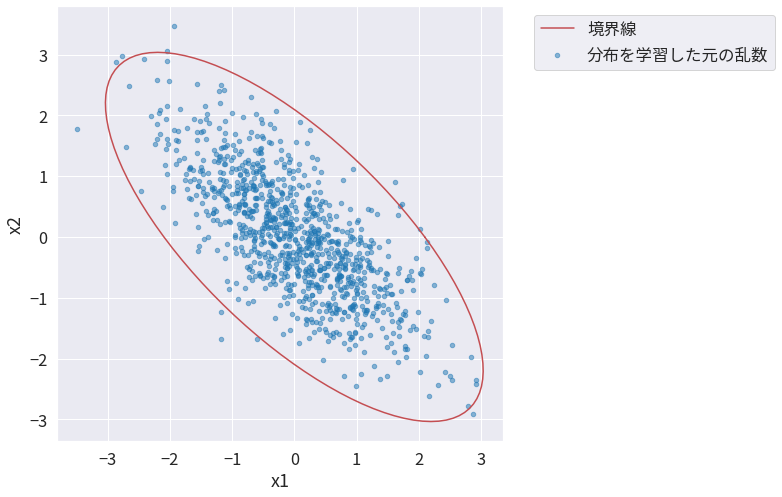

In [13]:
# 図を書く
fig, ax = plt.subplots(figsize=(8, 8))
X.plot(
    kind='scatter', x=X.columns[0], y=X.columns[1],
    color=sns.color_palette('tab10')[0], alpha=0.5, ax=ax,
    label='分布を学習した元の乱数'
)
ax.plot(limits[:, 0], limits[:, 1], 'r-', label='境界線')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

* マハラノビス距離が閾値であるデータを生成し、それを逆マハラノビス変換して、下のデータの散布図に境界線を描いた
* このように描いた境界線から、綺麗に分布を認識しており、異常検知できるだろうことが分かる
* いくつかの点は境界線の外にあるが、これは閾値の設定が悪いせい（笑）